In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import preprocessing
from keras import optimizers
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

2024-07-01 23:37:20.940164: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 23:37:20.943563: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 23:37:20.979520: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 23:37:21.037697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 23:37:21.095398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

In [2]:
data_dir = "archive (2)"
train_path = 'archive (2)/train'
test_path = 'archive (2)/test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [4]:
classes = { 
    0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)',
    9: 'No passing', 10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection',
    12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited', 17: 'No entry', 18: 'General caution',
    19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve',
    22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right',
    25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing',
    29: 'Bicycles crossing', 30: 'Beware of ice/snow', 31: 'Wild animals crossing',
    32: 'End speed + passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead',
    35: 'Ahead only', 36: 'Go straight or right', 37: 'Go straight or left',
    38: 'Keep right', 39: 'Keep left', 40: 'Roundabout mandatory',
    41: 'End of no passing', 42: 'End no passing vehicle with a weight greater than 3.5 tons'
}


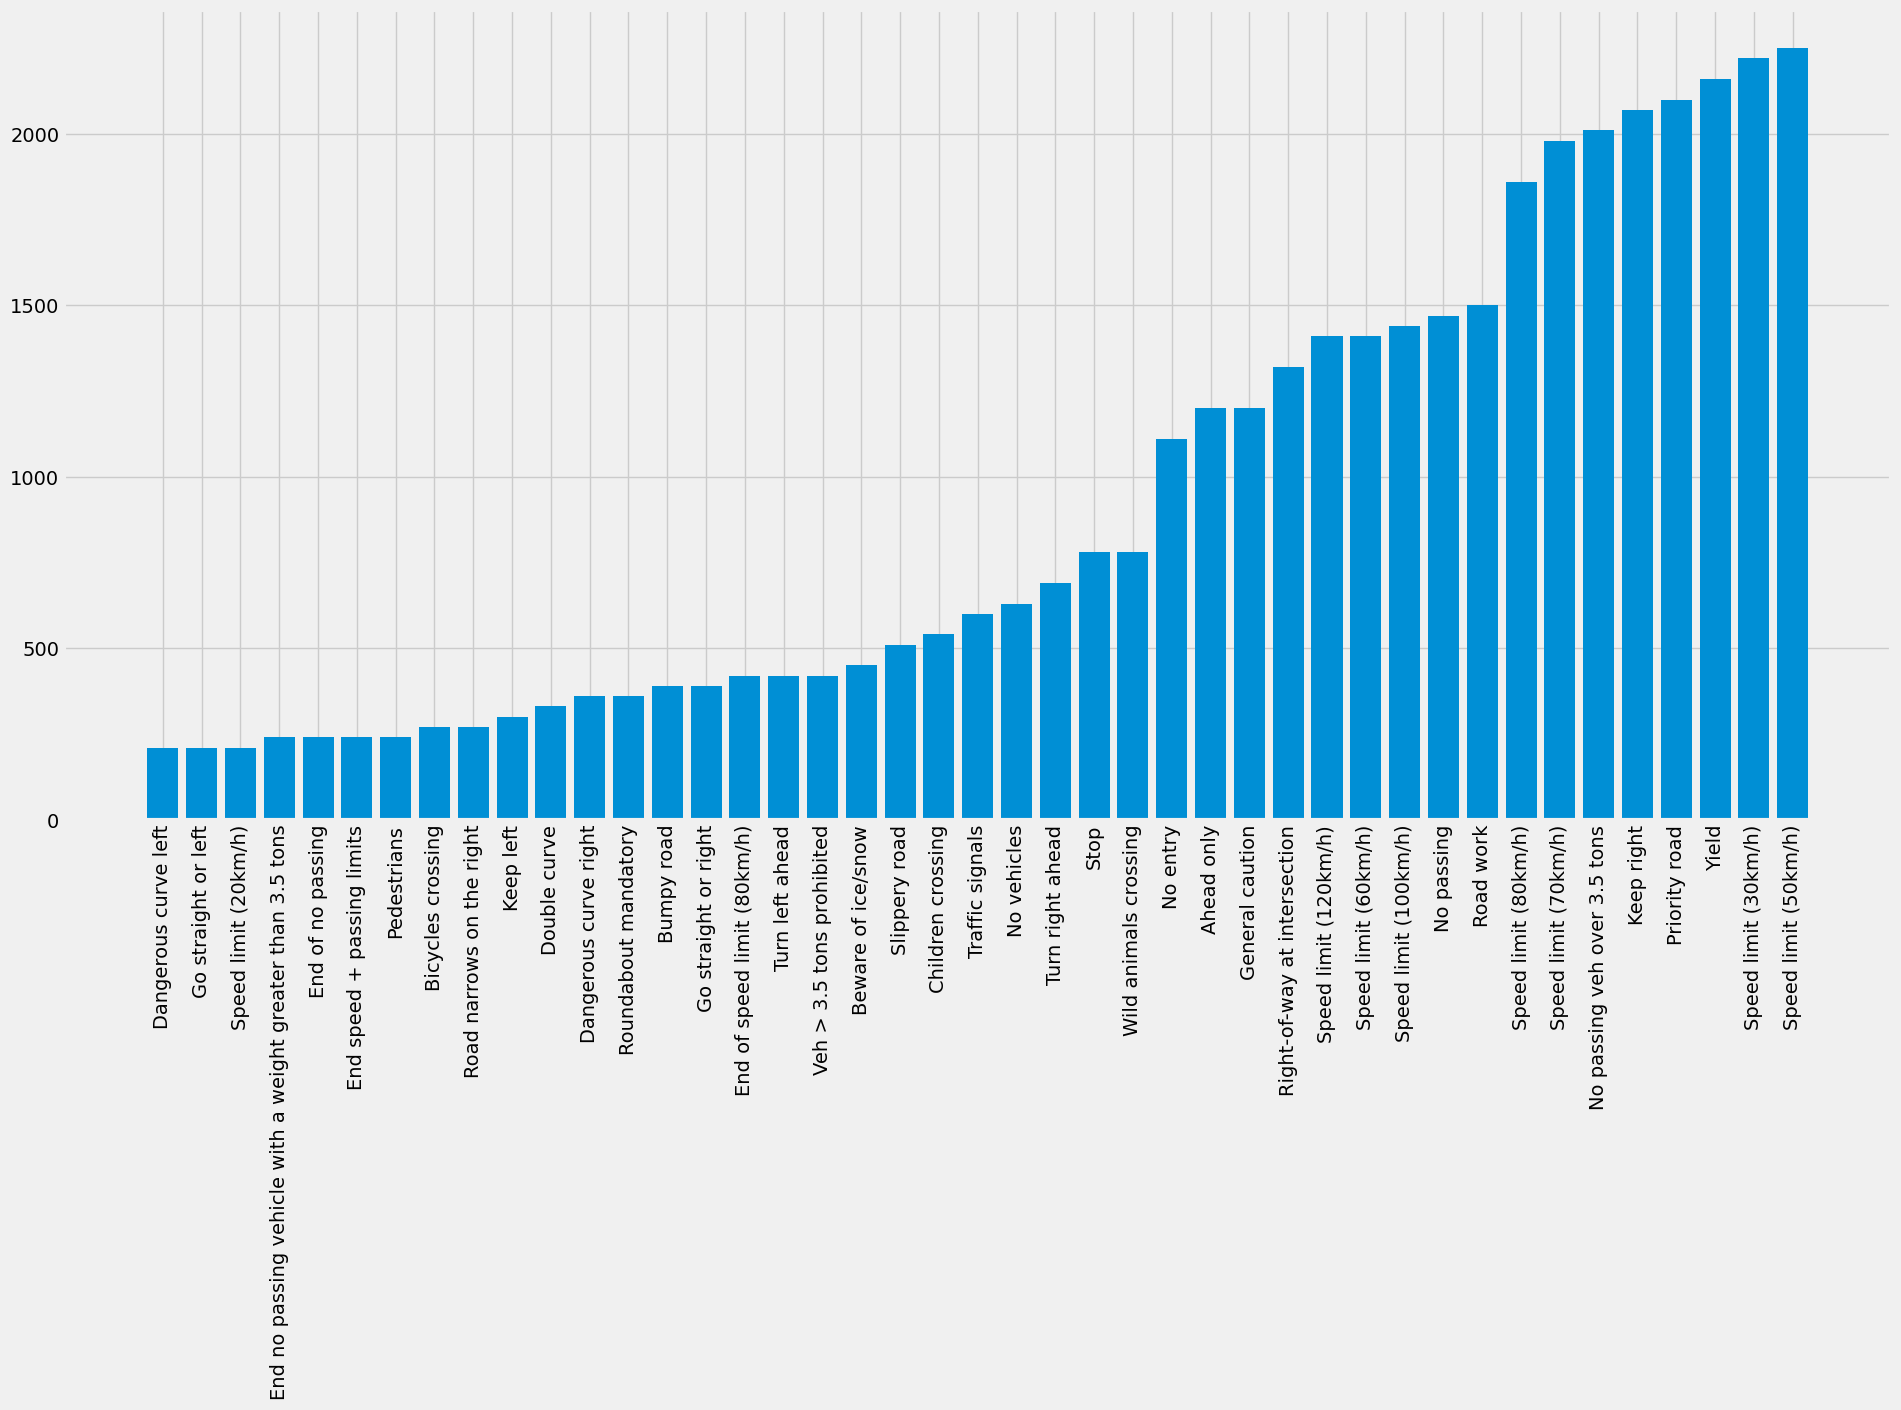

In [5]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

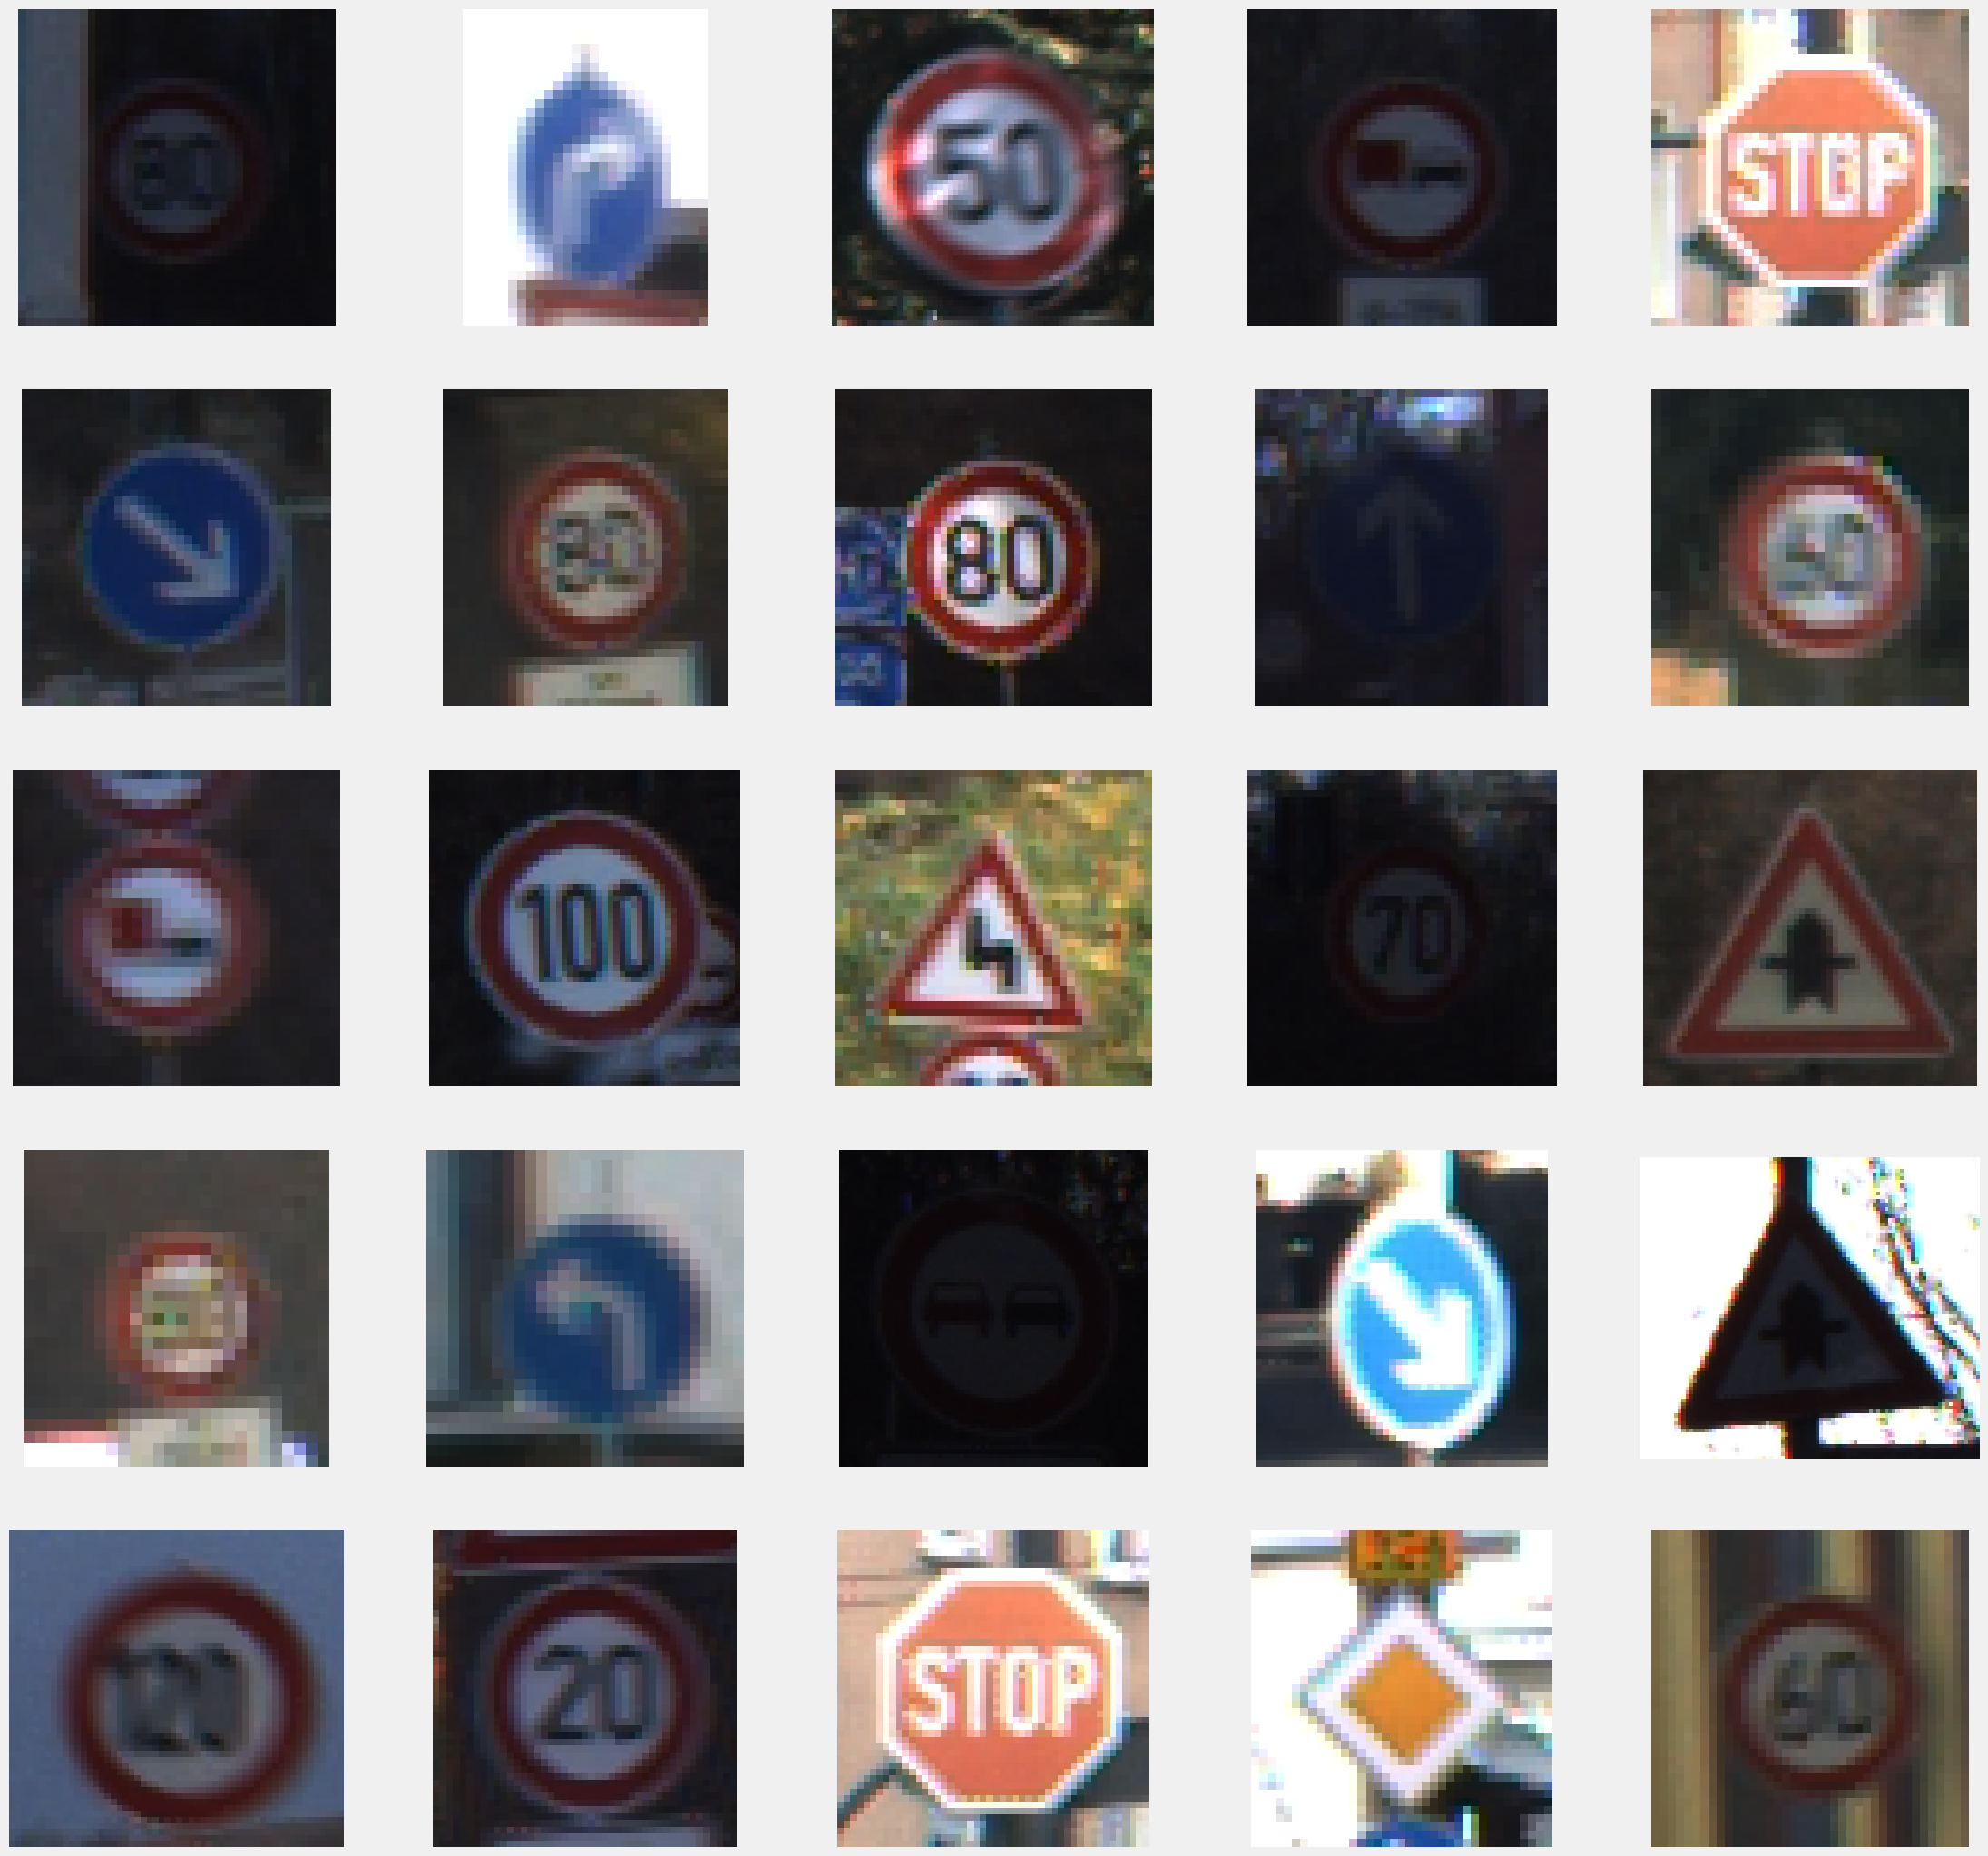

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.axis('off')
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image


In [7]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [9]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [10]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [11]:
from keras import models
from keras import layers
import pickle
model = models.Sequential([    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(axis=-1),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    
    layers.Dense(43, activation='softmax')
])
pickle_out= open("model_trained.p","wb")  # wb = WRITE BYTE
pickle.dump(model,pickle_out)
pickle_out.close()
cv2.waitKey(0)

/home/rutub/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


-1

In [12]:
lr = 0.001
epochs = 30

opt = optimizers.Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


/home/rutub/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [13]:

history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.7431 - loss: 1.0858 - val_accuracy: 0.9871 - val_loss: 0.0493
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.9885 - loss: 0.0420 - val_accuracy: 0.9889 - val_loss: 0.0396
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.9940 - loss: 0.0216 - val_accuracy: 0.9902 - val_loss: 0.0357
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.9916 - loss: 0.0261 - val_accuracy: 0.9822 - val_loss: 0.0604
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.9932 - loss: 0.0210 - val_accuracy: 0.9915 - val_loss: 0.0313
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 37s 43ms/step - accuracy: 0.9941 - loss: 0.0201 - val_accuracy: 0.9906 - val_loss: 0.0380
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.9938 - loss: 0.0199 - val_accuracy: 0.9903 - val_loss: 0.0362
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.9957 - loss: 0.0137 - 

In [14]:
model.save("model.h5")

In [15]:
pickle_out= open("model_trained.p","wb")  # wb = WRITE BYTE
pickle.dump(model,pickle_out)
pickle_out.close()
cv2.waitKey(0)

-1

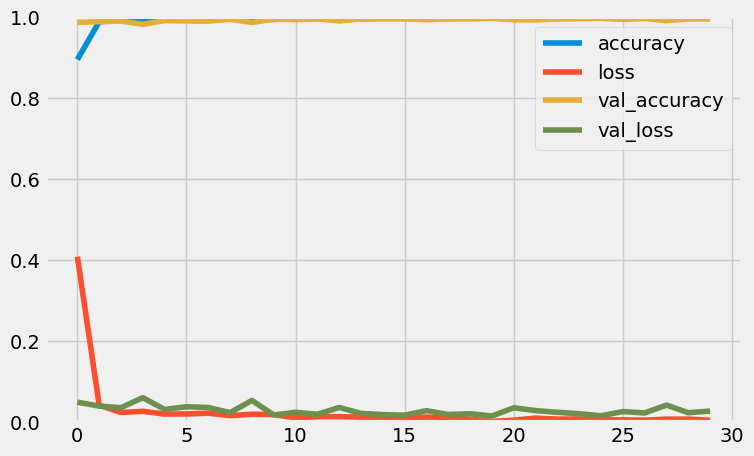

In [16]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [17]:
test = pd.read_csv(data_dir + '/Test.csv')
labels = test["ClassId"].values
imgs = test["Path"].values

data = []

# Process each image
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except Exception as e:
        print(f"Error in {img}: {e}")

# Convert list to numpy array and normalize
X_test = np.array(data)
X_test = X_test / 255.0

# Make predictions
pred = model.predict(X_test)
pred_classes = np.argmax(pred, axis=1)

# Ensure labels are in integer format
labels = labels.astype(int)

# Accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, pred_classes) * 100)

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Test Data accuracy:  98.03642121931908


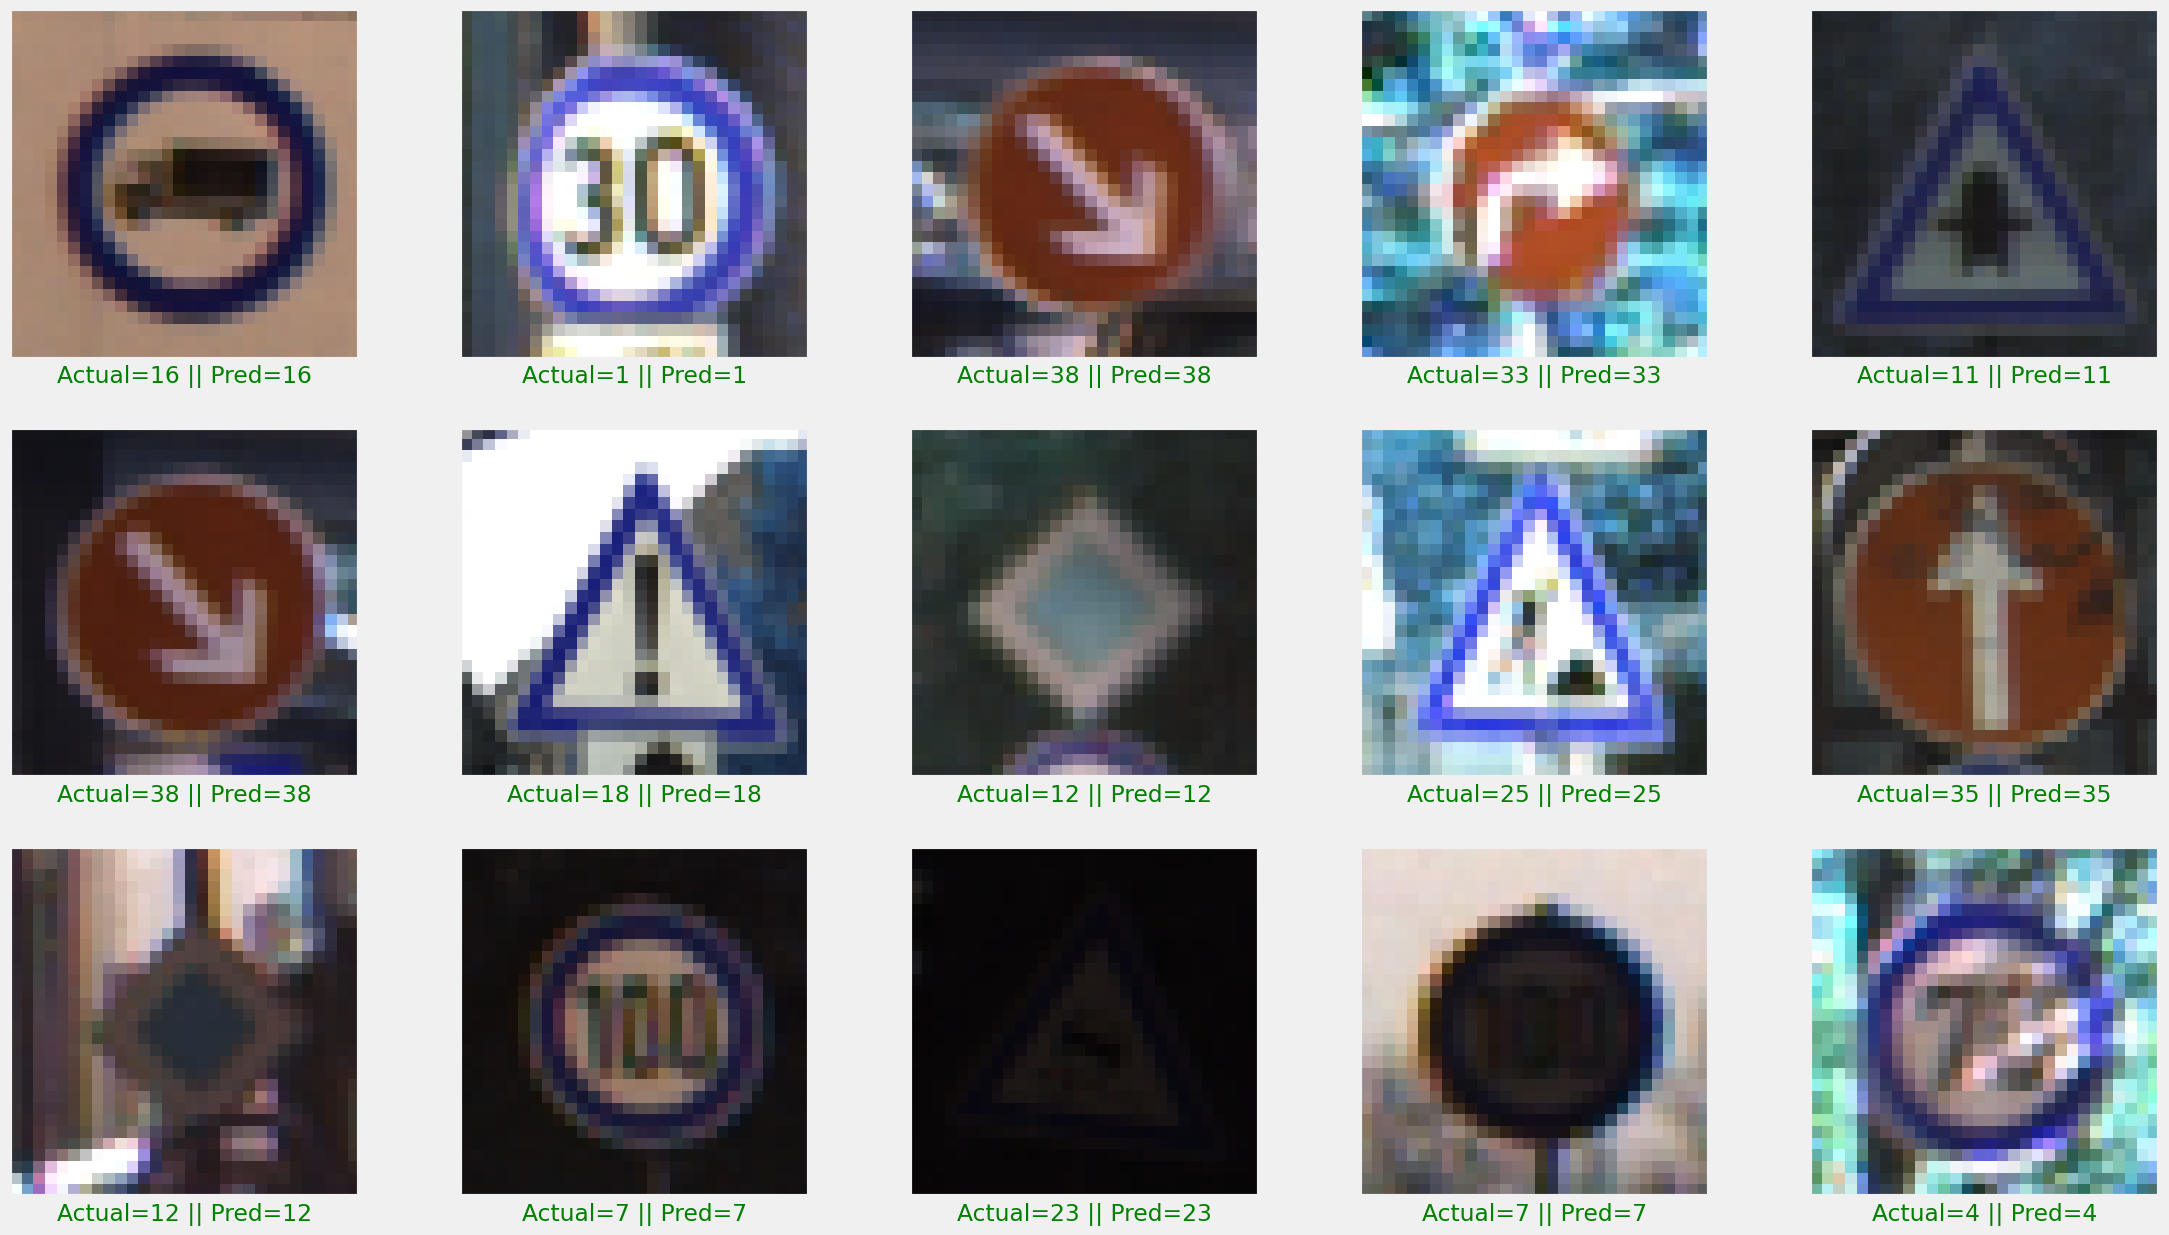

In [18]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_classes[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [19]:
import numpy as np
import cv2
import pickle
 
#############################################
 
frameWidth= 640         # CAMERA RESOLUTION
frameHeight = 480
brightness = 180
threshold = 0.75         # PROBABLITY THRESHOLD
font = cv2.FONT_HERSHEY_SIMPLEX

In [20]:
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10, brightness)

True

In [21]:
pickle_in=open("model_trained.p","rb")  ## rb = READ BYTE
model=pickle.load(pickle_in)
 

/home/rutub/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [22]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [ ]:
def getCalssName(classNo):
    if   classNo == 0: return 'Speed Limit 20 km/h'
    elif classNo == 1: return 'Speed Limit 30 km/h'
    elif classNo == 2: return 'Speed Limit 50 km/h'
    elif classNo == 3: return 'Speed Limit 60 km/h'
    elif classNo == 4: return 'Speed Limit 70 km/h'
    elif classNo == 5: return 'Speed Limit 80 km/h'
    elif classNo == 6: return 'End of Speed Limit 80 km/h'
    elif classNo == 7: return 'Speed Limit 100 km/h'
    elif classNo == 8: return 'Speed Limit 120 km/h'
    elif classNo == 9: return 'No passing'
    elif classNo == 10: return 'No passing for vechiles over 3.5 metric tons'
    elif classNo == 11: return 'Right-of-way at the next intersection'
    elif classNo == 12: return 'Priority road'
    elif classNo == 13: return 'Yield'
    elif classNo == 14: return 'Stop'
    elif classNo == 15: return 'No vechiles'
    elif classNo == 16: return 'Vechiles over 3.5 metric tons prohibited'
    elif classNo == 17: return 'No entry'
    elif classNo == 18: return 'General caution'
    elif classNo == 19: return 'Dangerous curve to the left'
    elif classNo == 20: return 'Dangerous curve to the right'
    elif classNo == 21: return 'Double curve'
    elif classNo == 22: return 'Bumpy road'
    elif classNo == 23: return 'Slippery road'
    elif classNo == 24: return 'Road narrows on the right'
    elif classNo == 25: return 'Road work'
    elif classNo == 26: return 'Traffic signals'
    elif classNo == 27: return 'Pedestrians'
    elif classNo == 28: return 'Children crossing'
    elif classNo == 29: return 'Bicycles crossing'
    elif classNo == 30: return 'Beware of ice/snow'
    elif classNo == 31: return 'Wild animals crossing'
    elif classNo == 32: return 'End of all speed and passing limits'
    elif classNo == 33: return 'Turn right ahead'
    elif classNo == 34: return 'Turn left ahead'
    elif classNo == 35: return 'Ahead only'
    elif classNo == 36: return 'Go straight or right'
    elif classNo == 37: return 'Go straight or left'
    elif classNo == 38: return 'Keep right'
    elif classNo == 39: return 'Keep left'
    elif classNo == 40: return 'Roundabout mandatory'
    elif classNo == 41: return 'End of no passing'
    elif classNo == 42: return 'End of no passing by vechiles over 3.5 metric tons'

In [ ]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)  # Try different indices if 0 does not work

if not cap.isOpened():
    print("Failed to open camera.")
    exit()

font = cv2.FONT_HERSHEY_SIMPLEX

while True:
    success, imgOrignal = cap.read()

    if not success:
        print("Failed to read frame from the camera!")
        break

    img = cv2.resize(imgOrignal, (32, 32))
    # Preprocess img if needed (grayscale, normalize, etc.)
    # img = preprocessing(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Example grayscale conversion

    cv2.imshow("Processed Image", img)

    img = img.reshape(1, 32, 32, 1)  # Reshape for model input

    predictions = model.predict(img)
    classIndex = np.argmax(predictions)
    probabilityValue = np.max(predictions)

    cv2.putText(imgOrignal, "CLASS: " + str(classIndex), (20, 35), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(imgOrignal, "PROBABILITY: " + str(round(probabilityValue*100, 2)) + "%", (20, 75), font, 0.75, (0, 0, 255), 2, cv2.LINE_AA)

    cv2.imshow("Result", imgOrignal)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

        
       
